# **Deep Learning Methods for Facial Emotion Recognition**

## **Transfer Learning using the EfficientNet B2 model**
------

# **Brief Overview**

This notebook is a continuation of the main Capstone project that included "attenuated transfer learning" that ended with suboptimal results.

By **attenuation** I mean that only the final convolutional block of each pretrained models was used.

The table below illustrates the performance of the three types of pretrained models with this attenuated method.

<br>

------------

<br>

The pretrained model discussed in this notebook is the EfficientNet B2 model. The convolutional (feature extraction) layers form the first part of this transfer learning model. The classification (fully connected) portion of the model is of my own construction.

<br>

-----------

<br>

## **FER 2013 Dataset**

**3 sets of data that each contain 4 classes (happy, sad, neutral, surprise)**
- **Training** set has 15,109 images
- **Validation** set has 4,977 images
- **Testing** set has 128 images

<br>

------------

<br>

## **Part 1: Frozen VGG16**

- The **feature extraction (EfficientNet B2)** portion is **FROZEN** - hyperparameters are as provided from the TensorFlow Keras environment.

- The **classification (fully connected) is unfrozen** and will learn new hyperparameter values during training on the FER 2013 dataset.

<br>

------------

<br>


## **Part 2: UN-Frozen VGG16**

- The **feature extraction (EfficientNet B2)** portion is **UN-FROZEN** - hyperparameters are allowed to change as the model is trained on the FER2013 dataset.

- The **classification (fully connected) remains unfrozen** and will learn new hyperparameter values during training on the FER 2013 dataset.

<br>

-----

## **Final data table with attenuated pretrained models, compared against custom made CNN models of my design**

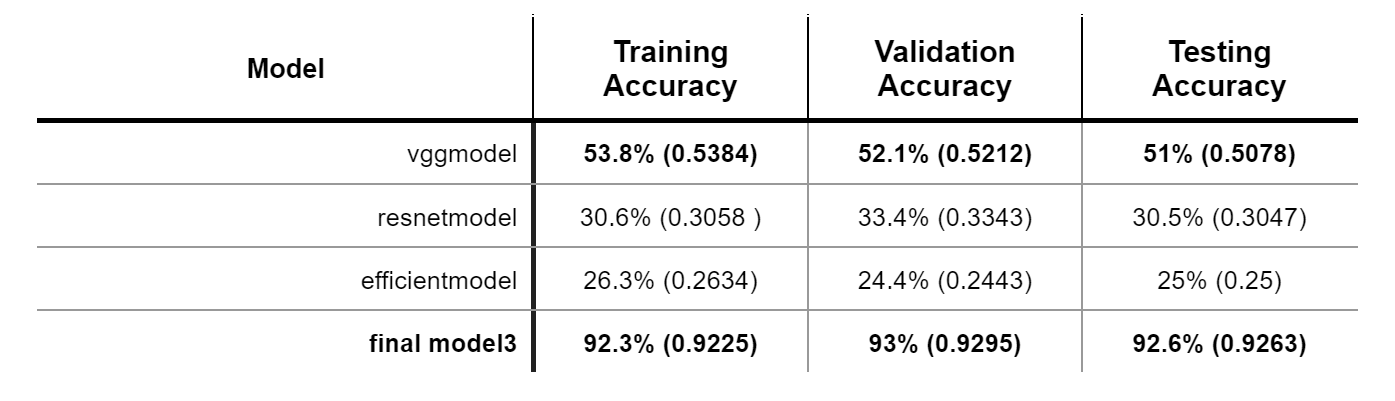

## **Final data table with attenuated pretrained models, compared against custom made CNN models of my design**

----
## **The table below shows performance data for the frozen models and the unfrozen models.**

- This model remains unoptimized and is the focus of future work.

<br>

------  

<br>

## **Key code changes to perform the analysis shown in this notebook include:**

- EfficientNet B2 expects an input shape of (260, 60, 3) while the FER 2013 dataset is 48 x 48. The data loader code resizes the FER 2013 images to 260 x 260

- Part 1 - The frozen model has the entire set of feature-extraction layers loaded in before my custom fully connected classification layers. This pretrained model (with parameters trained on 'imagenet') is then trained on the FER 2013 dataset. This will provide training only to my custom fully connected classification layers.

- Part 2 - The UNfrozen model also has the entire set of feature-extraction layers loaded in before my custom fully connected classification layers. During training, ALL layers (except for the batch normalization layers) take on new parameters.

![Table listing all the new data](all_data.png)

## **Mounting the Drive**

**NOTE:** It is recommended that you use Google Colab with the GPU option selected to open and run the code in this notebook. 

In [1]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

## **Importing relevant libraries**

In [ ]:
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Importing Deep Learning Libraries

import tensorflow as tf
import tensorflow.keras.applications as ap

from tensorflow.keras.applications import efficientnet

from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [ ]:
# Clearing backend
from tensorflow.keras import backend

backend.clear_session()

# Fixing the seed for random number generators
import random

np.random.seed(42)

random.seed(42)

tf.random.set_seed(42)

### **Load the data**
Same dataset as in Milestone 1 (FER 2013)

In [ ]:
# Path of the data file from the your drive location

path = '/YOUR-PATH/Facial_emotion_images.zip'

# Data is provided as a zip file. The following extracts these files

with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
picture_size = 48
folder_path = "Facial_emotion_images/"

## **Transfer Learning Architectures**
While in Milestone 1 both 'rgb' and 'grayscale' was used, the pre-trained models used in this Transfer Learning exercise requires the use of 'rgb'.

This informs the structure of the dataloaders (to include support for 3 channels - specifically the shape **(260, 260, 3)**.

The **pre-trained models** used below is the **EfficientNet B2**

As noted above, only the frozen pre-trained convolutional layers will be used, not the entire pre-trained model.

## **EfficientNet B2 Model**
The Efficient model comprises a feature-extraction section with **17 convolutional layers**, some with **3x3 filters** and others with **5x5 filters** and a classification section with three fully connected layers.

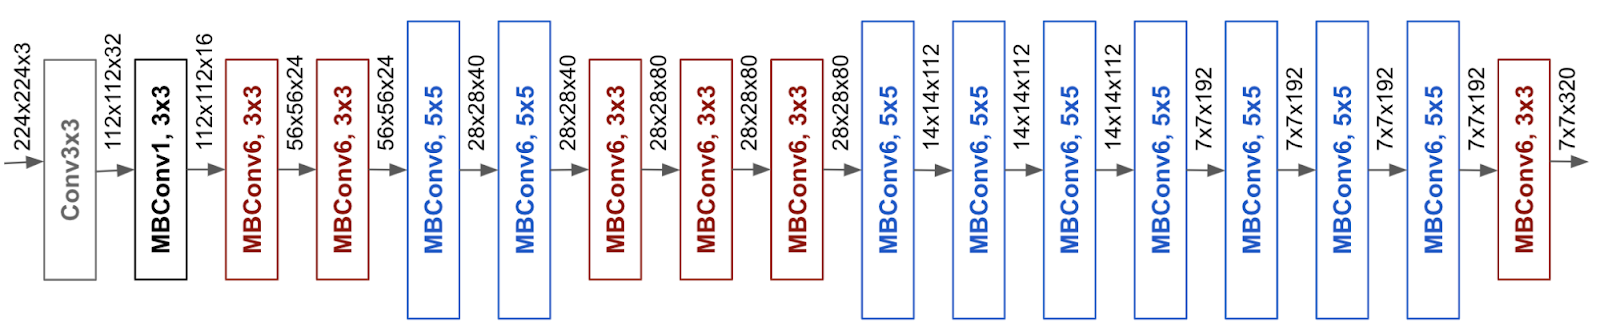

## **Importing the EfficientNet B2 Architecture**

In [ ]:
# 'include_top = False' is set this way to preserve the stability provided by unchanging parameters in the Batch Normalization' layers during the UNFROZEN section in Part 2, below.

EfficientNet = ap.EfficientNetB2(include_top = False, weights = "imagenet", input_shape = (260, 260, 3))

31790344/31790344 [==============================] - 0s 0us/step


## **Data Loader for data augmentation and preparation for use in the Transfer Learning Architectures**

In [ ]:
batch_size  = 32

# EfficientNet B2 expects an input_shape of 260, 260, 3
# If the model is set to False re: trainable then it can handle other shapes. If it is set to True then it MUST be set to 224, 224, 3
# https://keras.io/api/applications/efficientnet/#efficientnetb2-function

img_size = 260

datagen_train = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range = (0., 2.),
                                    rescale = 1./255,
                                    shear_range = 0.3)

train_set = datagen_train.flow_from_directory(folder_path + "train",
                                              target_size = (img_size, img_size),
                                              color_mode = 'rgb',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                              shuffle = True)

datagen_validation = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range = (0., 2.),
                                    rescale = 1./255,
                                    shear_range = 0.3)

validation_set = datagen_validation.flow_from_directory(folder_path + "validation",
                                              target_size = (img_size, img_size),
                                              color_mode = 'rgb',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                              shuffle = True)

datagen_test = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range = (0., 2.),
                                    rescale = 1./255,
                                    shear_range = 0.3)

test_set = datagen_test.flow_from_directory(folder_path + "test",
                                              target_size = (img_size, img_size),
                                              color_mode = 'rgb',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                              shuffle = True)

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


------------


## **Part 1: Frozen EfficientNet B2 model**

-------------
------------

<br>

- The **feature extraction (EfficientNet B2)** portion is **FROZEN** - hyperparameters are as provided from the TensorFlow Keras environment.

- The **classification (fully connected) is unfrozen** and will learn new hyperparameter values during training on the FER 2013 dataset.

<br>

------------

In [ ]:
# The frozen EfficientNet B2 model is set to False so that new values are not learned in the feature extraction portion

EfficientNet.trainable = False

# Flattening the output from the 6e layer the EfficientNet model
x = Flatten()(EfficientNet.output)

# Add a Dense layer with 256 neurons
x = Dense(256, activation = 'relu')(x)

# Add a Dense Layer with 128 neurons
x = Dense(128, activation = 'relu')(x)

# Add a DropOut layer with Drop out ratio of 0.3
x = Dropout(0.3)(x)

# Add a Dense Layer with 64 neurons
x = Dense(64, activation = 'relu')(x)

# Add a Batch Normalization layer
x = BatchNormalization()(x)

# Add the final dense layer with 4 neurons and use a 'softmax' activation
pred = Dense(4, activation = 'softmax')(x)


# Initializing the model
frozen_Efficientnetmodel = Model(EfficientNet.input, pred)

## **Visualizing the FROZEN EfficientNet B2 model**

In [ ]:
img_file = './Efficientnetmodel_base.png'

tf.keras.utils.plot_model(frozen_Efficientnetmodel, to_file=img_file, show_shapes=True, show_layer_names=True)

## **Setting up checkpoints**

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

EFfrozen_checkpoint = ModelCheckpoint("./Efficientnetmodel_frozen.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0,
                               patience = 3,
                               verbose = 1,
                               restore_best_weights = True
                               ) 

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                                        factor = 0.2,
                                        patience = 3,
                                        verbose = 1,
                                        min_delta = 0.0001) 

callbacks_list = [early_stopping,EFfrozen_checkpoint,reduce_learningrate]

epochs = 20

### **Compiling and Training the FROZEN EfficientNet B2 Model**

In [ ]:
# Compiling the FROZEN EfficientNet B2 model using loss function = categorical crossentropy, Adamax Optimizer with 0.001 learning rate and metrics to 'accuracy'.

frozen_Efficientnetmodel.compile(loss = 'categorical_crossentropy',
                          optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.001),
                          metrics = ['accuracy'])

In [ ]:
# Fitting the FROZEN EfficientNet B2 model using train_set as the training data and validation_set as the validation data, for 20 epochs.

history_efficientmodel_frozen = frozen_Efficientnetmodel.fit(train_set,
                                validation_data = validation_set,
                                epochs = 20)

Epoch 1/20
473/473 [==============================] - 330s 663ms/step - loss: 1.5182 - accuracy: 0.2504 - val_loss: 1.3665 - val_accuracy: 0.2506
Epoch 2/20
473/473 [==============================] - 310s 656ms/step - loss: 1.4314 - accuracy: 0.2575 - val_loss: 1.3753 - val_accuracy: 0.2443
Epoch 3/20
473/473 [==============================] - 308s 651ms/step - loss: 1.4097 - accuracy: 0.2633 - val_loss: 1.3553 - val_accuracy: 0.3667
Epoch 4/20
473/473 [==============================] - 309s 653ms/step - loss: 1.4041 - accuracy: 0.2598 - val_loss: 1.3707 - val_accuracy: 0.2443
Epoch 5/20
473/473 [==============================] - 308s 651ms/step - loss: 1.4033 - accuracy: 0.2567 - val_loss: 1.3629 - val_accuracy: 0.3667
Epoch 6/20
473/473 [==============================] - 310s 655ms/step - loss: 1.3994 - accuracy: 0.2597 - val_loss: 1.3655 - val_accuracy: 0.3673
Epoch 7/20
473/473 [==============================] - 308s 652ms/step - loss: 1.3966 - accuracy: 0.2599 - val_loss: 1.3532 -

### **Evaluating the FROZEN EfficientNet B2 model performance on training and validation data**

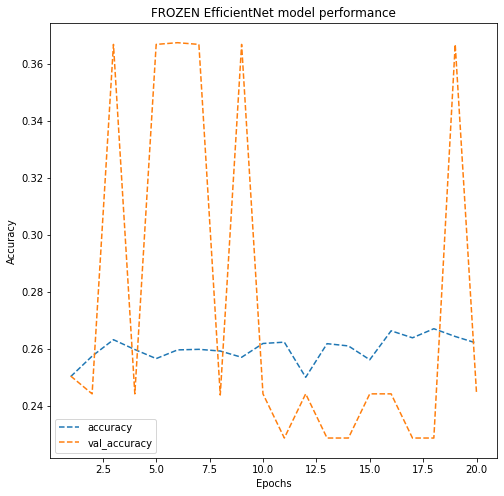

In [ ]:
# Plotting the accuracy curves for the training and validation sets of the FROZEN EfficientNet B2 model

dict_hist = history_efficientmodel_frozen.history

list_ep = [i for i in range(1, 21)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.title('FROZEN EfficientNet model performance')

plt.legend()

plt.show()

### **Evaluating the FROZEN EfficientNet B2 model performance on new TEST data*

In [ ]:
# Evaluating the FROZEN EfficientNet B2 model performance on the TEST SET

frozen_Efficientnetmodel.evaluate(test_set)

4/4 [==============================] - 2s 475ms/step - loss: 1.3912 - accuracy: 0.2500


[1.3911776542663574, 0.25]

------------

<br>


## **Part 2: UN-Frozen EfficientNet B2**

- The **feature extraction (EfficientNet B2)** portion is **UN-FROZEN** - hyperparameters are allowed to change as the model is trained on the FER2013 dataset.

- The **classification (fully connected) remains unfrozen** and will learn new hyperparameter values during training on the FER 2013 dataset.

<br>

-----------

In [ ]:
# In this UNFROZEN state, the weights and other parameters in the convolutional layers of the EfficientNet B2 model are allowed to change as the model is run through the FER 2013 training data

EfficientNet.trainable = True

# Flattening the output from the UN-FROZEN EfficientNet model
x = Flatten()(EfficientNet.output)

# Add a Dense layer with 256 neurons
x = Dense(256, activation = 'relu')(x)

# Add a Dense Layer with 128 neurons
x = Dense(128, activation = 'relu')(x)

# Add a DropOut layer with Drop out ratio of 0.3
x = Dropout(0.3)(x)

# Add a Dense Layer with 64 neurons
x = Dense(64, activation = 'relu')(x)

# Add a Batch Normalization layer
x = BatchNormalization()(x)

# Add the final dense layer with 4 neurons and use a 'softmax' activation
pred = Dense(4, activation = 'softmax')(x)


# Initializing the model
UNfrozen_Efficientnetmodel = Model(EfficientNet.input, pred)

## **Setting up checkpoints**

In [ ]:
UNfrozen_checkpoint = ModelCheckpoint("./Efficientnetmodel_UNfrozen.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0,
                               patience = 3,
                               verbose = 1,
                               restore_best_weights = True
                               ) 

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                                        factor = 0.2,
                                        patience = 3,
                                        verbose = 1,
                                        min_delta = 0.0001) 

callbacks_list = [early_stopping,UNfrozen_checkpoint,reduce_learningrate]

epochs = 20

### **Compiling and Training the UNFROZEN EfficientNet B2 model**

In [ ]:
# Compiling the UN-FROZEN EfficientNet B2 model with categorical crossentropy as the loss function, Adam Optimizer with 1e-05 learning rate, and set metrics to 'accuracy'.

UNfrozen_Efficientnetmodel.compile(loss = 'categorical_crossentropy',
                 optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
                 metrics = ['accuracy'])

In [ ]:
history_EfficientNet_UNfrozen = UNfrozen_Efficientnetmodel.fit(train_set,
                       validation_data = validation_set,
                       epochs = 20)

Epoch 1/20
473/473 [==============================] - 420s 860ms/step - loss: 1.4619 - accuracy: 0.3951 - val_loss: 1.2962 - val_accuracy: 0.3926
Epoch 2/20
473/473 [==============================] - 406s 857ms/step - loss: 1.2036 - accuracy: 0.4941 - val_loss: 1.1394 - val_accuracy: 0.5071
Epoch 3/20
473/473 [==============================] - 406s 858ms/step - loss: 1.0738 - accuracy: 0.5532 - val_loss: 2.0737 - val_accuracy: 0.1955
Epoch 4/20
473/473 [==============================] - 405s 855ms/step - loss: 1.0009 - accuracy: 0.5834 - val_loss: 1.3083 - val_accuracy: 0.3392
Epoch 5/20
473/473 [==============================] - 405s 857ms/step - loss: 0.9448 - accuracy: 0.6097 - val_loss: 1.0291 - val_accuracy: 0.5572
Epoch 6/20
473/473 [==============================] - 405s 856ms/step - loss: 0.8953 - accuracy: 0.6226 - val_loss: 1.2982 - val_accuracy: 0.3601
Epoch 7/20
473/473 [==============================] - 405s 856ms/step - loss: 0.8631 - accuracy: 0.6488 - val_loss: 1.0342 -

### **Evaluating the UN-FROZEN EfficientNet B2 model performance on training and validation data**

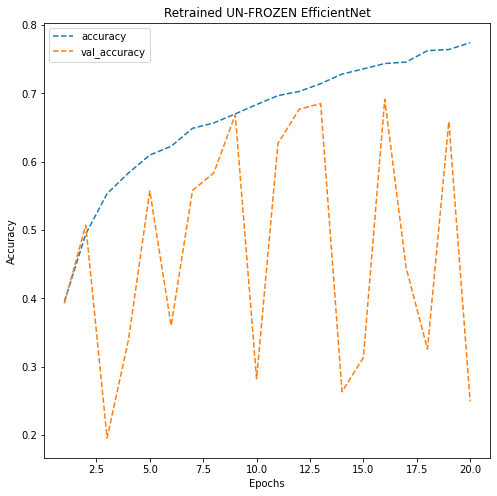

In [ ]:
# Plotting the accuracy curves for the training and validation sets of the UN-FROZEN EfficientNet B2 model

dict_hist = history_EfficientNet_UNfrozen.history

list_ep = [i for i in range(1, 21)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.title('Retrained UN-FROZEN EfficientNet')

plt.legend()

plt.show()

### **Evaluating the UN-FROZEN EfficientNet B2 model performance on new TEST data**

In [ ]:
# Evaluating the UN-FROZEN EfficientNet B2 model performance on the TEST SET

UNfrozen_Efficientnetmodel.evaluate(test_set)

4/4 [==============================] - 2s 485ms/step - loss: 1.4407 - accuracy: 0.2812


[1.4407416582107544, 0.28125]